In [13]:
from baseline import transform_test_data
from eval import evaluate_clusters_iou, count_matches, evaluate_clusters_entropy
from api_utils import run_inference
from prompt_lib import agent_prompt, meta_prompt, reflect_prompt, reflect_prompt_2
from meta_utils import run_meta_inference, run_agent_inference
import json
import numpy as np
import matplotlib.pyplot as plt

In [14]:
%env TOGETHER_API_KEY=eb25e0d054aec138257edf3c264089a5fa04be265ce8c3890597884cec1bc622

env: TOGETHER_API_KEY=eb25e0d054aec138257edf3c264089a5fa04be265ce8c3890597884cec1bc622


In [15]:
def average_iou(predicted_answers, test_data):
    ious = []
    for i in range(len(test_data)):
        pred_clusters = predicted_answers[i]
        true_clusters = test_data[i]['solutions']
        print(pred_clusters)
        print(true_clusters)
        iou = evaluate_clusters_iou(pred_clusters=pred_clusters, true_clusters=true_clusters)
        ious.append(iou)
    avg_iou = sum(ious) / len(ious)
    return avg_iou

In [16]:
with open('data/splits/connections_mini_test.json', 'r') as file:
    data = json.load(file)
test_data = transform_test_data(data, False)

predicted_answers = await run_inference(test_data, agent_prompt, model="databricks/dbrx-instruct")

with open('data/meta/iter_1_answers.json', 'w') as file:
    json.dump(predicted_answers, file)

print("average IOU loss in test set for iteration 1: ", average_iou(predicted_answers, test_data))

scores = [average_iou(predicted_answers, test_data)]

for i in range(2,5):
    with open(f'data/meta/iter_{i-1}_answers.json', 'r') as file:
        agent_responses = json.load(file)

    meta_instructions = await run_meta_inference(prompt = meta_prompt, instructions = agent_prompt, games = test_data, responses = agent_responses, model="databricks/dbrx-instruct")

    #predicted_answers = await run_agent_inference(prompt = reflect_prompt, instructions = agent_prompt, games = test_data, responses = agent_responses, meta_instructions = meta_instructions, model="databricks/dbrx-instruct")
    predicted_answers = await run_agent_inference(prompt = reflect_prompt_2, instructions = agent_prompt, games = test_data, responses = agent_responses, meta_instructions = meta_instructions, model="databricks/dbrx-instruct")

    with open(f'data/meta/iter_{i}_answers.json', 'w') as file:
        json.dump(predicted_answers, file)
    score = average_iou(predicted_answers, test_data)
    scores.append(score)
    print("average IOU loss in test set for iteration ", i, ": ", score)

[[['SIGHT', 'HEARING', 'TOUCH', 'SMELL'], ['SAME', 'LIKEWISE', 'DITTO', 'MANNER'], ['BLUE', 'NEW', 'SECOND', 'HARVEST'], ['DRESS', 'STYLE', 'TASTE', 'SAILOR']], [['NOISE', 'STATIC', 'BUMP', 'KNOCK'], ['PROUD', 'INTENSE', 'DEEP', 'EXTREME'], ['HAIL', 'SNOW', 'FUZZ', 'BUTT'], ['RAM', 'BLOODY', 'VIRGIN', 'FIERCE'], [''], ['Explanation'], [''], ['NOISE', 'STATIC', 'BUMP', 'KNOCKThesearealltypesofsoundsordisturbances'], ['PROUD', 'INTENSE', 'DEEP', 'EXTREMEThesearealladjectivesthatdescribestrongemotionsorfeelings'], ['HAIL', 'SNOW', 'FUZZ', 'BUTTTheseareallwordsthatcanbeassociatedwithwinterorcoldweatherFuzzisaslangtermforsnow'], ['RAM', 'BLOODY', 'VIRGIN', 'FIERCETheseareallwordsthatcanbeassociatedwithastrongoraggressiveanimal', 'suchasaramBloodyandfierceareadjectivesthatdescribeastrongoraggressiveanimal', 'andvirgincanrefertoayoungorinexperiencedanimal']], [['FLIPPER', 'FIN', 'TAIL', 'BALL'], ['IRE', 'FOG', 'MIST', 'HAZE'], ['CLOUD', 'SHADOW', 'ICE', 'NETHER'], ['TRACK', 'TRAIL', 'PLUNGER'

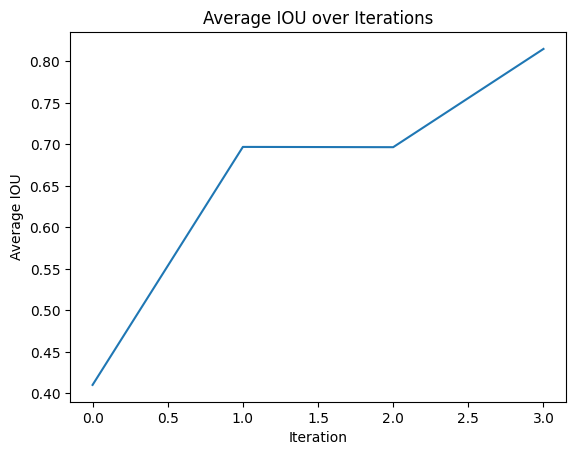

In [20]:
#plot with each score clearly labeled
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Average IOU')
plt.title('Average IOU over Iterations')
plt.show()